# Predicting xylose transport

Now that the dataset is fully cleaned, we can start analysing the best features to describe it and design a predictive model

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
%matplotlib inline

In [2]:
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("full_features.csv",index_col=0)
df.head()

A         R         N         D         C         E         Q  \
P0CD99  0.072250  0.039409  0.032841  0.036125  0.029557  0.049261  0.024631   
P39932  0.075571  0.042179  0.047452  0.038664  0.015817  0.054482  0.031634   
P18631  0.063492  0.033510  0.033510  0.042328  0.022928  0.044092  0.028219   
P15325  0.082552  0.046904  0.045028  0.020638  0.007505  0.050657  0.026266   
Q12300  0.074705  0.031455  0.076016  0.040629  0.011796  0.039318  0.031455   

               G         H         I  ...  Galactose  Arabinose  Mannose  \
P0CD99  0.070608  0.008210  0.068966  ...          0          0        0   
P39932  0.080844  0.014060  0.072056  ...          0          0        0   
P18631  0.091711  0.014109  0.079365  ...          0          0        1   
P15325  0.106942  0.011257  0.084428  ...          0          0        0   
Q12300  0.072084  0.017038  0.093054  ...          0          0        0   

        Xylose_Paper  PS00216  PS00217  HMM_seq_E-value  HMM_seq_score  \
P0CD99           0.0      0.0      1.0        12.055517           42.8   
P39932           0.0      1.0      0.0        12.004365           42.6   
P18631           0.0      1.0      1.0        20.585027           70.1   
P15325           0.0      1.0      1.0        10.522879           37.8   
Q12300           0.0      1.0      1.0        11.920819           42.4   

        HMM_dom_E-value  HMM_dom_score  
P0CD99         9.292430           33.9  
P39932         8.481486           31.3  
P18631        10.508638           37.8  
P15325         4.552842           18.7  
Q12300         6.853872           26.1  

[5 rows x 31766 columns]

After runnning CD-HIT with .8 similarity threshold, some proteins were removed from the dataset. So we should remove them from the dataframe. Xylose transporters that were removed were re-added manually to the index file below

In [4]:
with open("fungi_bac_cdhit80.txt") as f:
    new_indices = [i.strip() for i in f]

In [5]:
for i in df.index:
    if i not in new_indices:
        df.drop(i,inplace=True)

In [6]:
df.shape

(396, 31766)

In [7]:
df.query("Xylose==1").shape

(25, 31766)

---

#### Split the dataframe into train and test

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df.drop("Xylose",axis=1)
y = df["Xylose"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

### Feature selection

Most features are non descriptive and hinder a model's generalization capabilities. RFECV is a great way to select the subset of features that can describe our data

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

The cell below is here only for registration purposes as this step was done on a server cluster.
RFECV was run with scoring `f1` and `f1 weighted`; `step=5` and `step=1`

```python
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=5, n_jobs=1)
feature_selection = RFECV(xgb_model, cv=StratifiedKFold(5), scoring="f1_weighted", step=5, n_jobs=1)
feature_selection.fit(X_train, y_train)

with open("xgb_rfecv_features.pickle","wb") as f:
    pickle.dump(feature_selection, f)
```

The model with `step=5` was better than with `step=1` for some reason; also, `f1` was the same as `f1_weighted` and thus the pickle file was removed (plots not shown)

In [12]:
with open("xgb_rfecv_features.pickle","rb") as f:
    feature_selection = pickle.load(f)

/home/matt/anaconda3/envs/machine_learning_transporters/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/matt/anaconda3/envs/machine_learning_transporters/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RFECV from version 0.20.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
print("Optimal number of features: {}".format(feature_selection.n_features_),"\n")
print("Selected features: {}".format(X_train.iloc[:,feature_selection.get_support(indices=True)].columns))

Optimal number of features: 13 

Selected features: Index(['GFV', 'BIGC670101.lag17', 'DAYM780201.lag16', 'Pc1.C', 'M.T.lag4',
       'I.A.lag5', 'PSSM_49_E', 'PSSM_120_V', 'PSSM_489_V', 'PSSM_523_D',
       'PSSM_679_M', 'scl5.2.lag5', 'HMM_seq_E-value'],
      dtype='object')


Reshape `X` to only optimal features

In [14]:
X_train = X_train.iloc[:,feature_selection.get_support(indices=True)]
X_test = X_test.iloc[:,feature_selection.get_support(indices=True)]

---

#### Visualizing features

In [15]:
from yellowbrick.features import Rank1D, Rank2D

/home/matt/anaconda3/envs/machine_learning_transporters/lib/python3.7/site-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


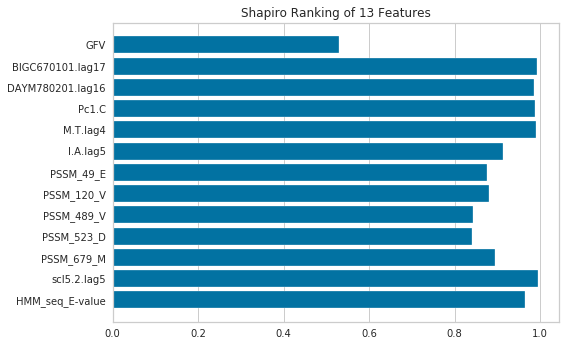

In [16]:
visualizer_1d = Rank1D(features=X_train.columns)
visualizer_1d.fit(X_train, y_train)
visualizer_1d.transform(X_train)
visualizer_1d.poof()

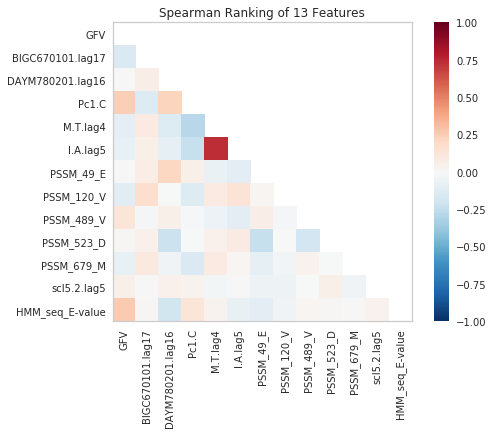

In [17]:
visualizer_2d = Rank2D(features=X_train.columns, algorithm="spearman")
visualizer_2d.fit(X_train, y_train)
visualizer_2d.transform(X_train)
visualizer_2d.poof()

In [18]:
shap.initjs()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


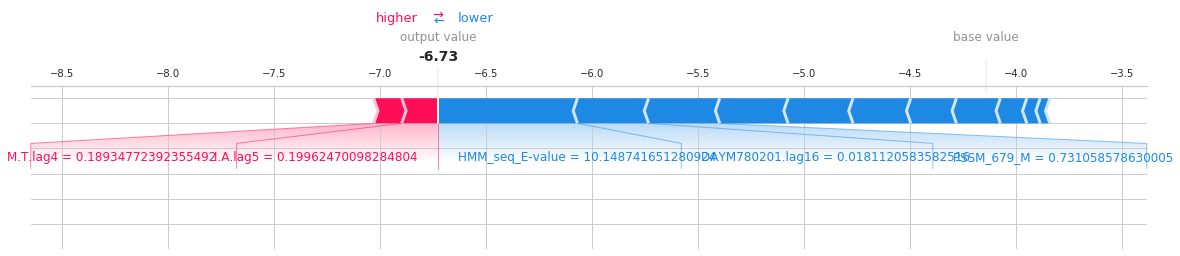

In [19]:
explainer = shap.TreeExplainer(feature_selection.estimator_)
shap_values = explainer.shap_values(X_train.values)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


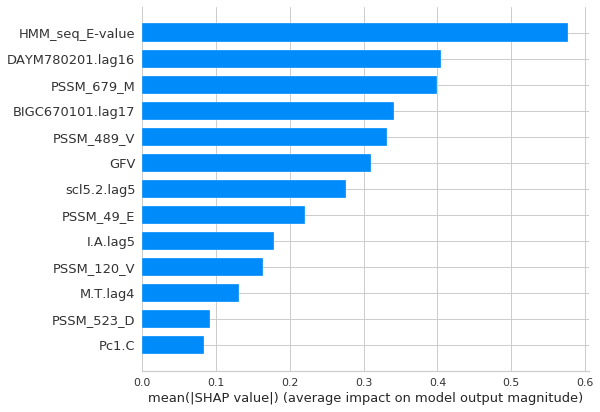

In [20]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

----

#### Dealing with imbalance on this dataset - Oversampling xylose=1 class

If the class to predict is umbalanced, the model won't be able to detect it; statistical transformations to mitigate this are essential.

In [21]:
import umap
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

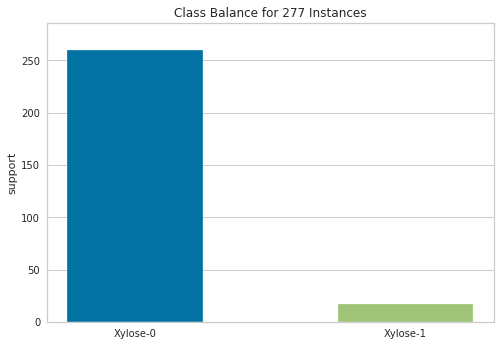

In [22]:
from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels=["Xylose-0","Xylose-1"])
visualizer.fit(y_train)
visualizer.poof()

In [23]:
ros = RandomOverSampler(random_state=0)
smote = SMOTE(sampling_strategy="minority", random_state=0, kind="borderline1", k_neighbors=2)
adasyn = ADASYN(sampling_strategy="minority", random_state=0,n_neighbors=2)
smoteenn = SMOTEENN(sampling_strategy="minority", random_state=0,smote=smote)
smotetomek = SMOTETomek(random_state=0, sampling_strategy="minority")

X_resampled_ros, y_resampled_ros = ros.fit_sample(X_train, y_train)
X_resampled_smote, y_resampled_smote = smote.fit_sample(X_train, y_train)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_sample(X_train, y_train)
X_resampled_smoteenn , y_resampled_smoteenn = smoteenn.fit_sample(X_train, y_train)
X_resampled_smotetomek , y_resampled_smotetomek = smotetomek.fit_sample(X_train, y_train)

In [24]:
check_ros = umap.UMAP(random_state=0).fit_transform(X_resampled_ros)
check_smote = umap.UMAP(random_state=0).fit_transform(X_resampled_smote)
check_adasyn = umap.UMAP(random_state=0).fit_transform(X_resampled_adasyn)
check_smoteenn = umap.UMAP(random_state=0).fit_transform(X_resampled_smoteenn)
check_smotetomek = umap.UMAP(random_state=0).fit_transform(X_resampled_smotetomek)
check_original = umap.UMAP(random_state=0).fit_transform(X_train)

/home/matt/anaconda3/envs/machine_learning_transporters/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../anaconda3/envs/machine_learning_transporters/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/matt/anaconda3/envs/machine_learning_transporters/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../anaconda3/envs/machine_learning_transporters/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_i

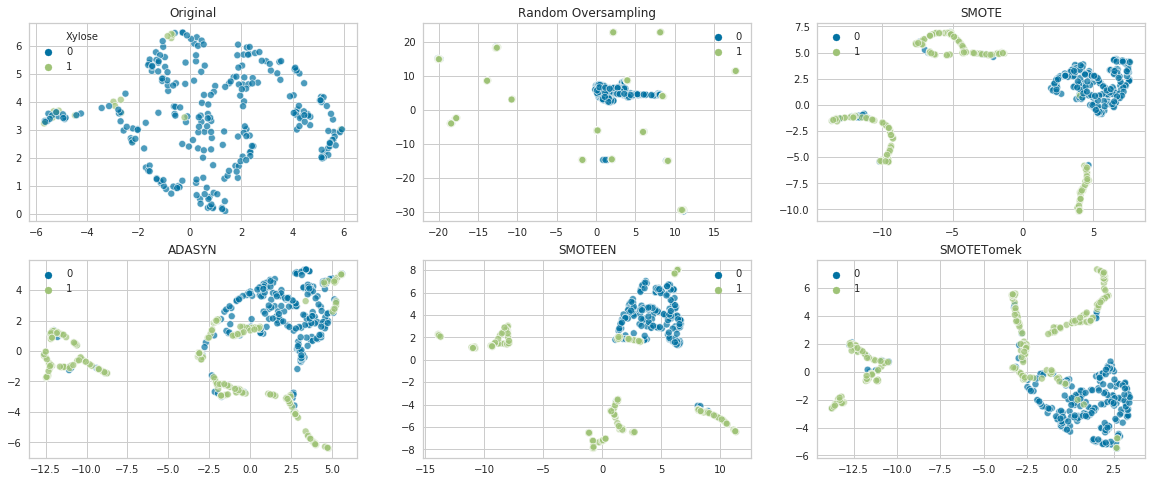

In [25]:
fig, ((ax,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(figsize=(20,8), nrows=2, ncols=3)

sns.scatterplot(check_original[:,0],check_original[:,1], hue=y_train, alpha=0.7, ax=ax)
sns.scatterplot(check_ros[:,0],check_ros[:,1], hue=y_resampled_ros, alpha=0.7, ax=ax1)
sns.scatterplot(check_smote[:,0],check_smote[:,1], hue=y_resampled_smote, alpha=0.7, ax=ax2)
sns.scatterplot(check_adasyn[:,0],check_adasyn[:,1], hue=y_resampled_adasyn, alpha=0.7, ax=ax3)
sns.scatterplot(check_smoteenn[:,0],check_smoteenn[:,1], hue=y_resampled_smoteenn, alpha=0.7, ax=ax4)
sns.scatterplot(check_smotetomek[:,0],check_smotetomek[:,1], hue=y_resampled_smotetomek, alpha=0.7, ax=ax5)


ax.set_title("Original");
ax1.set_title("Random Oversampling");
ax2.set_title("SMOTE");
ax3.set_title("ADASYN");
ax4.set_title("SMOTEEN");
ax5.set_title("SMOTETomek");

Apparently SMOTEENN (and SMOTE) managed to separate the two classes better than other algorithms, however, some samples on the Xylose-0 cluster have been added as Xylose-1, but are most likely Xylose-0 (and vice-versa). Their tag should be changed

In [26]:
mask = np.invert((check_smoteenn[:,0]>=0) & (check_smoteenn[:,1]>=-2.5) & (y_resampled_smoteenn == 1))
y_resampled_smoteenn = y_resampled_smoteenn[mask]
X_resampled_smoteenn = X_resampled_smoteenn[mask,:]

In [27]:
check_smoteenn_filtered = umap.UMAP(random_state=0).fit_transform(X_resampled_smoteenn)

In [28]:
#y_resampled_smoteenn[(check_smoteenn[:,0]>=0) & (check_smoteenn[:,1]>=-2.5)] = 0

#y_resampled_smote[(check_smote[:,0]<=0) & (check_smote[:,1]<=-2.5)] = 1

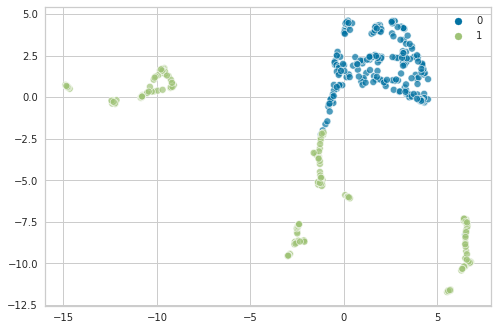

In [29]:
sns.scatterplot(check_smoteenn_filtered[:,0],check_smoteenn_filtered[:,1], hue=y_resampled_smoteenn, alpha=0.7)

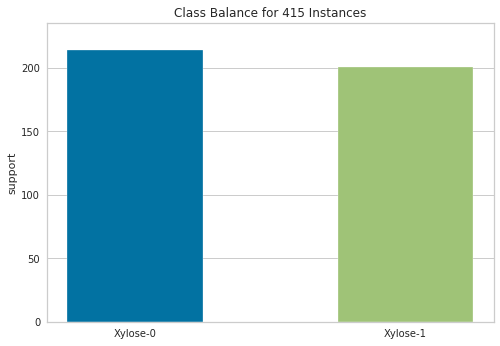

In [30]:
visualizer = ClassBalance(labels=["Xylose-0","Xylose-1"])
visualizer.fit(y_resampled_smoteenn)
visualizer.poof()

---

#### Visualize the model

In [31]:
import xgboost as xgb

In [32]:
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix, ClassPredictionError

In [33]:
def plot_all(model,X,y):
    classes = ["Xylose-0", "Xylose-1"]
    
    pr_rc = PrecisionRecallCurve(model)
    pr_rc.fit(X, y)
    pr_rc.score(X_test.values, y_test)
    pr_rc.poof()
    
    roc = ROCAUC(model, classes=classes)
    roc.fit(X, y)
    roc.score(X_test.values, y_test)
    roc.poof()
    
    fig, ax = plt.subplots()
    cm = ConfusionMatrix(model)
    cm.fit(X, y)
    cm.score(X_test.values, y_test)
    ax.set_xticklabels(["Xylose-0","Xylose-1"], rotation=45)
    ax.set_yticklabels(["Xylose-1","Xylose-0"])
    ax.text(x=2.1,y=1,
            s=f"""False positive rate: {cm.confusion_matrix_[0][1]/sum(cm.confusion_matrix_[0])}
False negative rate: {cm.confusion_matrix_[1][0]/sum(cm.confusion_matrix_[1])}""")
    cm.poof()
    
    print(f"False positive rate: {cm.confusion_matrix_[0][1]/sum(cm.confusion_matrix_[0])}")
    print(f"False negative rate: {cm.confusion_matrix_[1][0]/sum(cm.confusion_matrix_[1])}")
    
    err = ClassPredictionError(model, classes=classes)
    err.fit(X, y)
    err.score(X_test.values, y_test)
    err.poof()

In [34]:
xgb_model = xgb.XGBClassifier(random_state=5, n_jobs=1, base_score=0.8, scale_pos_weight=0.2)

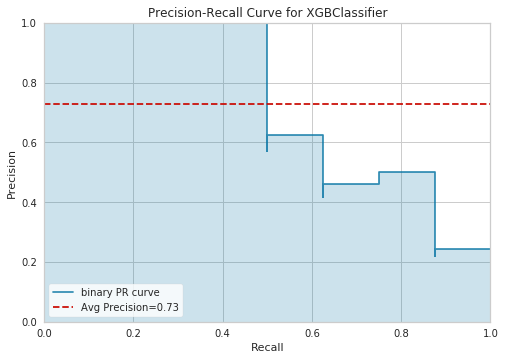

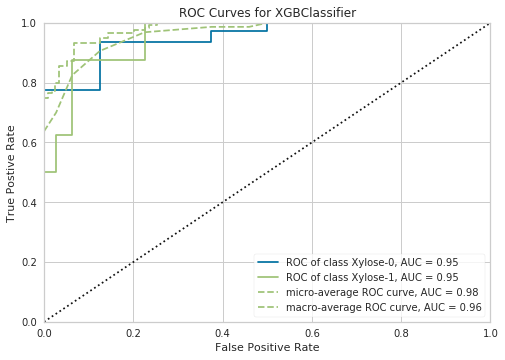

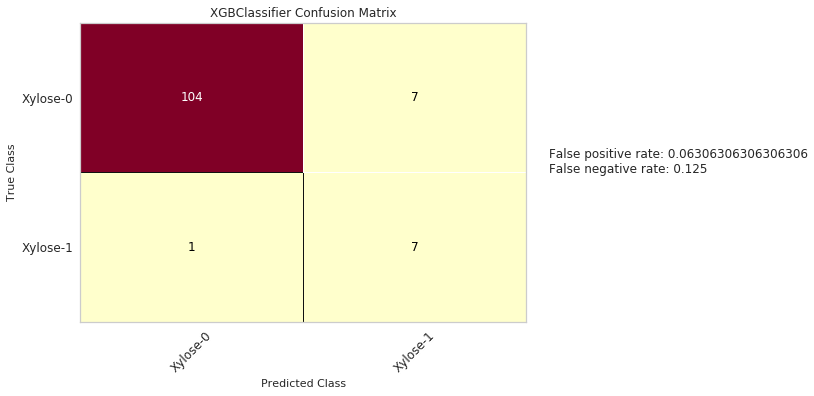

False positive rate: 0.06306306306306306
False negative rate: 0.125


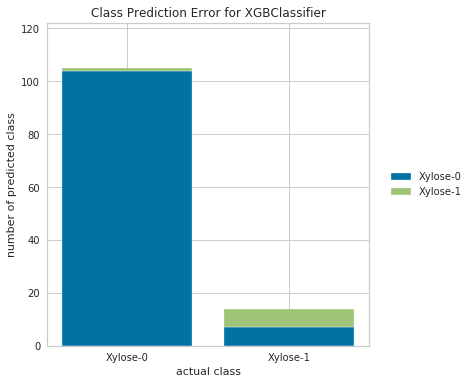

In [35]:
plot_all(xgb_model, X_resampled_smoteenn, y_resampled_smoteenn)

The default threshold for classifying one class or the other is 0.5 (maybe the `base_value` is what changes this threshold). What would happen to the model if we manually changed predictions to a higher threshold?

In [36]:
from yellowbrick.classifier import DiscriminationThreshold

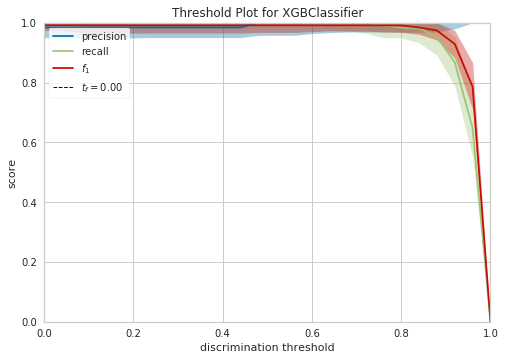

In [37]:
disc = DiscriminationThreshold(xgb_model, cv=0.3, n_trials=50, exclude="queue_rate")
disc.fit(X_resampled_smoteenn, y_resampled_smoteenn)
disc.poof()

In [49]:
probs = xgb_model.predict_proba(X_test.values)
predictions_default = xgb_model.predict(X_test.values)
predictions_threshold = [1 if i[1]>0.98 else 0 for i in probs]

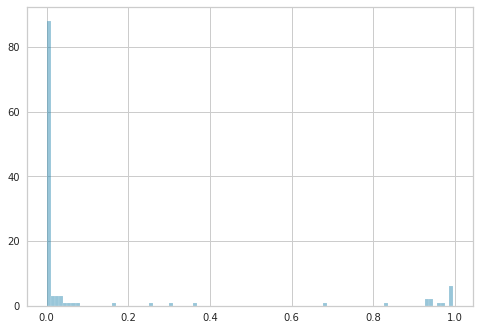

In [50]:
sns.distplot(probs[:,1], bins=100, kde=False)

In [102]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef

In [103]:
def get_cm_and_metrics(threshold):
    probs = xgb_model.predict_proba(X_test.values)
    predictions_default = xgb_model.predict(X_test.values)
    predictions_threshold = [1 if i[1]>threshold else 0 for i in probs]
    cm = confusion_matrix(y_test,predictions_threshold)
    print(cm)
    print(f"False positive rate: {cm[0][1]/sum(cm[0])}")
    print(f"False negative rate: {cm[1][0]/sum(cm[1])}")
    print(f"Precision: {precision_score(y_test, predictions_threshold)}")
    print(f"Recall: {recall_score(y_test, predictions_threshold)}")
    print(f"Accuracy: {accuracy_score(y_test, predictions_threshold)}")
    print(f"Balanced accuracy: {balanced_accuracy_score(y_test, predictions_threshold)}")
    print(f"MCC: {matthews_corrcoef(y_test, predictions_threshold)}")

In [104]:
get_cm_and_metrics(0.5)

[[104   7]
 [  1   7]]
False positive rate: 0.06306306306306306
False negative rate: 0.125
Precision: 0.5
Recall: 0.875
Accuracy: 0.9327731092436975
Balanced accuracy: 0.9059684684684685
MCC: 0.631059217297185


In [105]:
get_cm_and_metrics(0.98)

[[109   2]
 [  4   4]]
False positive rate: 0.018018018018018018
False negative rate: 0.5
Precision: 0.6666666666666666
Recall: 0.5
Accuracy: 0.9495798319327731
Balanced accuracy: 0.740990990990991
MCC: 0.5515976905540976


In [106]:
get_cm_and_metrics(0.99)

[[111   0]
 [  5   3]]
False positive rate: 0.0
False negative rate: 0.625
Precision: 1.0
Recall: 0.375
Accuracy: 0.957983193277311
Balanced accuracy: 0.6875
MCC: 0.5990293873396795


In [107]:
get_cm_and_metrics(0.96)

[[108   3]
 [  3   5]]
False positive rate: 0.02702702702702703
False negative rate: 0.375
Precision: 0.625
Recall: 0.625
Accuracy: 0.9495798319327731
Balanced accuracy: 0.7989864864864865
MCC: 0.597972972972973


In [48]:
# with open("xgb_model.pickle", "wb") as f:
    # pickle.dump(xgb_model,f)

---

## Hyperparameter tuning with GridSearchCV

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm.

The same kind of machine learning model can require different constraints, weights or learning rates to generalize different data patterns. These measures are called hyperparameters, and have to be tuned so that the model can optimally solve the machine learning problem. Hyperparameter optimization finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given independent data

In [43]:
from sklearn.model_selection import GridSearchCV

```python
params = {"learning_rate":[.01, .1, .2, .5],
          "booster":["gbtree", "gblinear", "dart"],
          "scale_pos_weight":[.5, .8, 1],
          "n_estimators":[100, 200, 500, 1000],
          "random_state":[42]}

grid = GridSearchCV(feature_selection.estimator_, param_grid=params, scoring="f1_weighted",
                   cv=StratifiedKFold(5))

with open("grid_search_xgb.pickle", "wb") as :
    pickle.dump(grid, f)
```